# Soil parameters estimation

**Thoughts**

mean values per each band per patch?

pred from mean or mean of preds?

test svm?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from torch.utils.data import DataLoader
from xgboost import XGBRegressor

from src.consts import MAX_PATH
from src.data.dataset import HyperviewDataset
from src.models.modeller import Modeller

## Read model and dataset

In [2]:
IMG_SIZE = 100
CHANNELS = 150
K = 5
NUM_PARAMS = 3
MAX_VAL = 6000
BATCH_SIZE = 16

MODEL_PATH = "output/modeller_var=GaussianRenderer_bias=Mean_k=5_masked.pth"

In [3]:
dir = "data/hyperview/train_data/train_data"
gt_path = "data/hyperview/train_data/train_gt.csv"

In [4]:
model = Modeller(IMG_SIZE, CHANNELS, K, NUM_PARAMS)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [5]:
with open(MAX_PATH, "rb") as f:
    maxx = np.load(f)
maxx[maxx > MAX_VAL] = MAX_VAL

In [6]:
dataset = HyperviewDataset(dir, IMG_SIZE, MAX_VAL, 0, maxx, mask=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [21]:
def prepare_datasets(dataloader: DataLoader) -> list[np.ndarray]:
    imgs = []
    preds = []
    for data in dataloader:
        pred = model(data)
        pred = pred.detach().numpy()
        shift = pred[:,0,2:]
        # print(shift.shape)
        pred[:,:, 2] = shift
        # print(pred.shape)
        mask = data[:, 0] == 0

        expanded_mask = np.expand_dims(mask, axis=1)
        crop_mask = np.repeat(expanded_mask, repeats=150, axis=1)
        masked_data = np.where(crop_mask == 0, data, np.nan)

        expanded_mask = np.expand_dims(np.expand_dims(mask, axis=1), axis=2)
        crop_mask = np.repeat(np.repeat(expanded_mask, repeats=5, axis=1), repeats=3, axis=2)
        masked_pred = np.where(crop_mask == 0, pred, np.nan)

        data_mean = np.nanmax(masked_data, axis=(2, 3))
        pred_mean = np.nanmax(masked_pred, axis=(3, 4))
        imgs.append(data_mean)
        preds.append(pred_mean)
    return imgs, preds

Features - mean per patch

In [22]:
imgs, preds = prepare_datasets(dataloader)

In [23]:
imgs = np.array(imgs)
preds = np.array(preds)

In [24]:
img_means = imgs.reshape(imgs.shape[0] * BATCH_SIZE, CHANNELS)
pred_means = preds.reshape(preds.shape[0] * BATCH_SIZE, K * NUM_PARAMS)

In [25]:
gt = pd.read_csv(gt_path)
gt.head()

,sample_index,P,K,Mg,pH
0,0,45.1,188.0,179.0,7.2
1,1,44.8,205.0,188.0,7.0
2,2,44.4,207.0,145.0,6.8
3,3,46.5,204.0,143.0,6.8
4,4,52.0,212.0,167.0,6.7


In [26]:
gt = gt[:img_means.shape[0]]
gt = gt.drop(["sample_index"], axis=1)

In [27]:
x_img = img_means
y = gt

In [38]:
x_pred = np.delete(pred_means, [5, 8, 11, 14], axis=1)
x_pred.shape

(1728, 11)

In [39]:
x_pred[0]

array([0.38991454, 0.43547323, 0.04177428, 0.40991858, 0.609289  ,
       0.40252388, 0.59566736, 0.39324993, 0.5601564 , 0.36395425,
       0.5087393 ], dtype=float32)

In [40]:
np.std(x_pred, axis=0), np.mean(x_pred, axis=0)

(array([0.03117906, 0.03303466, 0.09725746, 0.00682197, 0.0332201 ,
        0.01591371, 0.04561627, 0.03174859, 0.01568466, 0.09572447,
        0.01820656], dtype=float32),
 array([0.43302256, 0.47869018, 0.08249541, 0.41743025, 0.6106246 ,
        0.42420676, 0.6243767 , 0.43214494, 0.5606881 , 0.44319943,
        0.5034174 ], dtype=float32))

## Predictions using XGBoost

In [41]:
def predict_params(x_train: np.ndarray, x_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray) -> np.ndarray:
    model = MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=1e-3))
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    mse = mean_squared_error(y_test, preds, multioutput="raw_values")
    return mse

In [42]:
def samples_number_experiment(x: np.ndarray, y: np.ndarray, sample_nums: list[int]) -> list[np.ndarray]:
    x_train_base, x_test, y_train_base, y_test = train_test_split(x, y, test_size=0.2, random_state=8)
    mses = [predict_params(x_train_base, x_test, y_train_base, y_test)]
    for sn in sample_nums:
        x_train, y_train = x_train_base[:sn], y_train_base[:sn]
        mses.append(predict_params(x_train, x_test, y_train, y_test))
    return mses

In [43]:
samples = [1000, 500, 200, 100, 50, 10]

In [44]:
mses_img = np.array(samples_number_experiment(x_img, y, samples))
mses_pred = np.array(samples_number_experiment(x_pred, y, samples))

In [45]:
samples_ticks = [1382, 1000, 500, 200, 100, 50, 10]

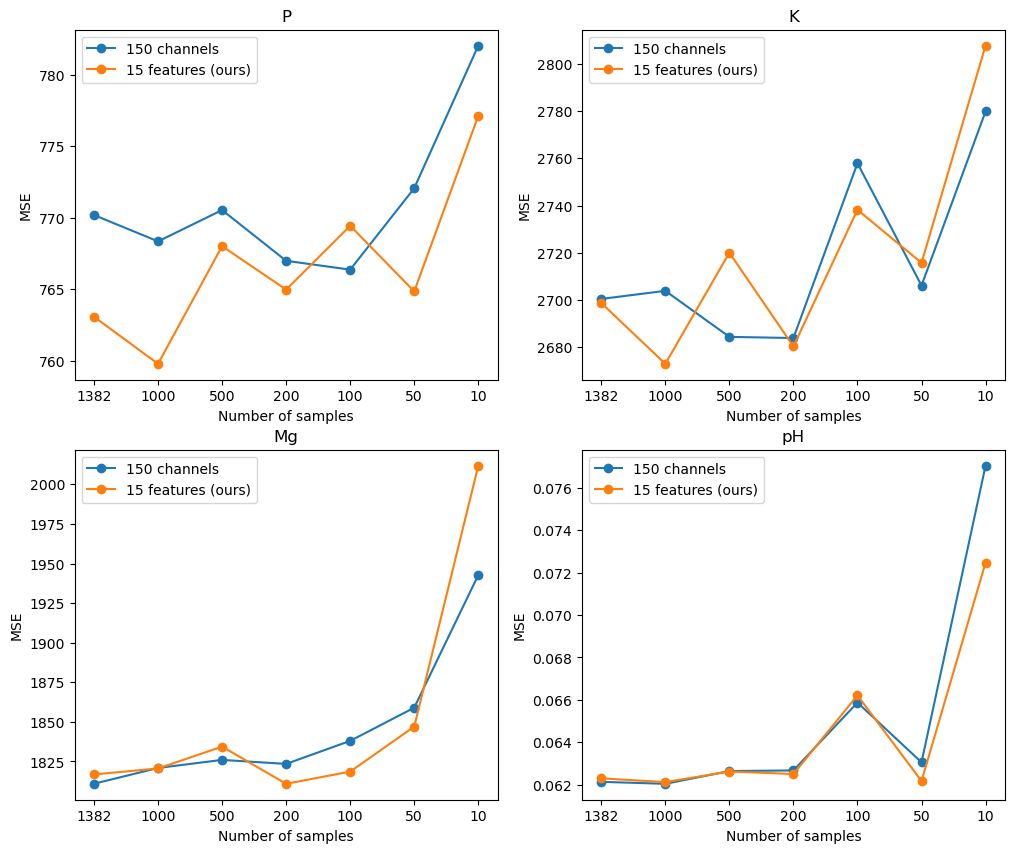

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, ax in enumerate(fig.axes):
    ax.plot(mses_img[:, i], "-o", label="150 channels")
    ax.plot(mses_pred[:, i], "-o", label="15 features (ours)")
    ax.legend()
    ax.set_xlabel("Number of samples")
    ax.set_ylabel("MSE")
    ax.set_title(gt.columns[i])
    ax.set_xticks(list(range(len(samples_ticks))))
    ax.set_xticklabels(samples_ticks)

In [49]:
def predict_params(x_train: np.ndarray, x_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray) -> np.ndarray:
    model = MultiOutputRegressor(XGBRegressor(n_estimators=100, learning_rate=1e-3))
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    mse = mean_squared_error(y_test, preds, multioutput="raw_values")
    return mse


def samples_number_experiment(x: np.ndarray, y: np.ndarray, sample_nums: list[int], n_runs: int = 10) -> tuple[list[np.ndarray], list[np.ndarray]]:
    mses_mean = []
    mses_std = []
    
    for sn in sample_nums:
        mses_for_sample = []
        
        for run in range(n_runs):
            x_train_base, x_test, y_train_base, y_test = train_test_split(x, y, test_size=0.2, random_state=run)
            x_train, y_train = x_train_base[:sn], y_train_base[:sn]

            mse = predict_params(x_train, x_test, y_train, y_test)
            mses_for_sample.append(mse)
        
        mses_for_sample = np.array(mses_for_sample)
        mses_mean.append(mses_for_sample.mean(axis=0))
        mses_std.append(mses_for_sample.std(axis=0))
    
    return mses_mean, mses_std

# samples = [1382, 1000, 750, 500, 250, 100, 50,  25, 10]
samples = [1382, 250, 200, 150, 100, 50, 25, 10]


mses_mean_img, mses_std_img = samples_number_experiment(x_img, y, samples)
mses_mean_pred, mses_std_pred = samples_number_experiment(x_pred, y, samples)

mses_mean_img = np.array(mses_mean_img)
mses_std_img = np.array(mses_std_img)
mses_mean_pred = np.array(mses_mean_pred)
mses_std_pred = np.array(mses_std_pred)

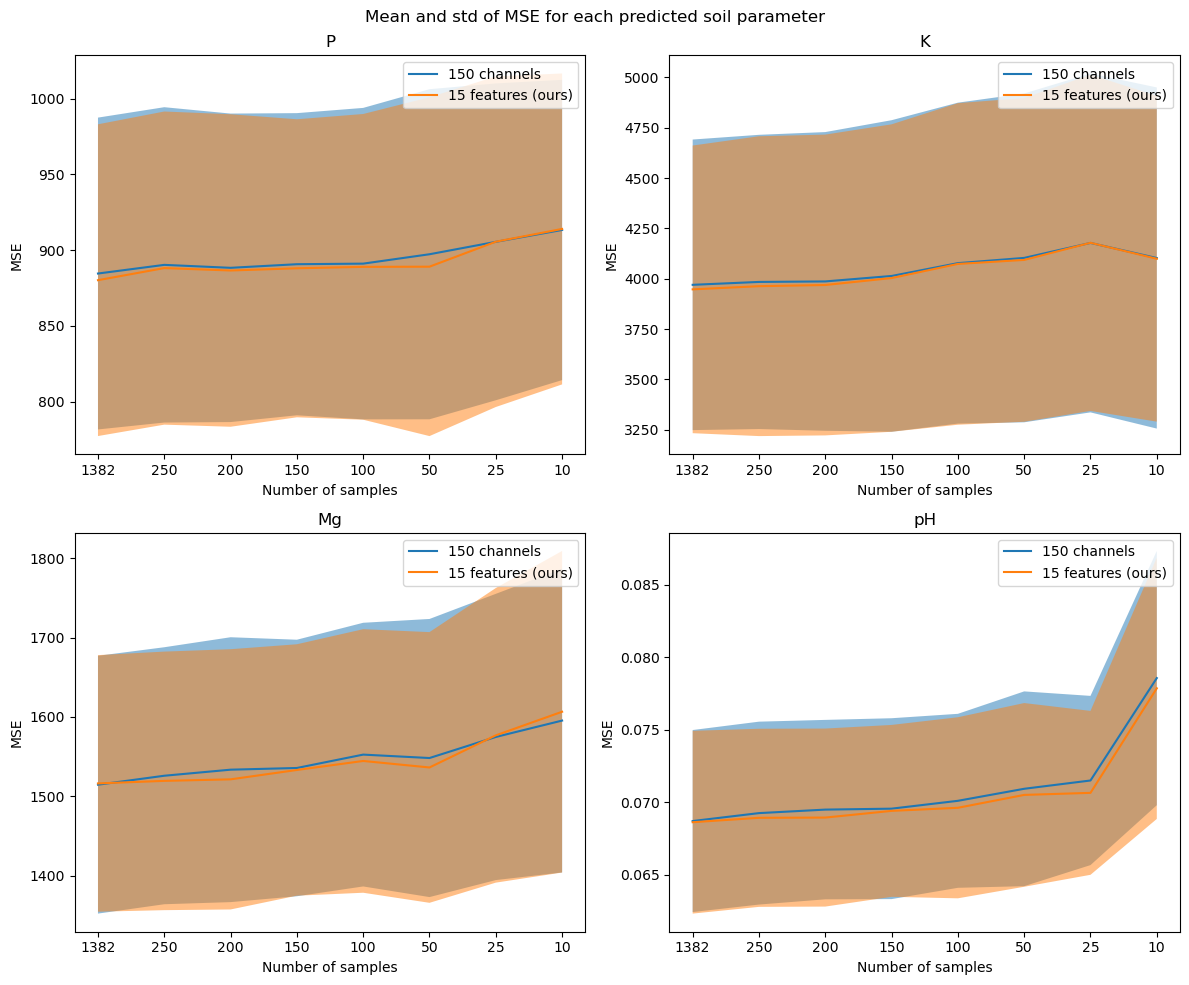

In [50]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Mean and std of MSE for each predicted soil parameter")
x = list(range(len(samples)))

for i, ax in enumerate(fig.axes):
    ax.fill_between(x, mses_mean_img[:, i] - mses_std_img[:, i], mses_mean_img[:, i] + mses_std_img[:, i], alpha=0.5)
    ax.fill_between(x, mses_mean_pred[:, i] - mses_std_pred[:, i], mses_mean_pred[:, i] + mses_std_pred[:, i], alpha=0.5)
    ax.plot(x, mses_mean_img[:, i], '-', label="150 channels")
    ax.plot(x, mses_mean_pred[:, i], '-', label="15 features (ours)")

    ax.legend()
    ax.set_xlabel("Number of samples")
    ax.set_ylabel("MSE")
    ax.set_title(gt.columns[i])
    ax.set_xticks(x)
    ax.set_xticklabels(samples)

plt.tight_layout()
plt.show()